In [1]:
from Spatial_VGAE_prodLDA_final_all import *

/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import copy
import numpy as np
import scipy
import pandas as pd
from tqdm import trange
from pathlib import Path
import scanpy as sc
import squidpy as sq
import cellcharter as cc
sc.set_figure_params(dpi=120)
import anndata
import seaborn
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering
import torch
import torch_geometric as pyg
from torch_geometric.nn import VGAE, GCNConv, InnerProductDecoder, Sequential
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warning

In [3]:
# generate an adata with rows as spots (it doesn't matter whether columns are genes or PCs) and contains obsm['spatia'] for the spatial coordinates
# the obsm['spatial'] will be used to construct the adjacency matrix by delauney triangulation implemented in squidpy, and the long adjacency edges will be filtered out using the implementation in cellcharter

counts = pd.read_csv('mouse_hypothalamic/counts_-0.14.tsv', sep='\t', header=0, index_col=0)
print(counts.iloc[:5,:5])
counts = counts.T
print(counts.iloc[:5,:5])
counts = counts.drop(columns=counts.columns[ counts.isnull().sum(axis=0) > 0 ])
print(counts.iloc[:5,:5])

df2 = pd.read_csv('mouse_hypothalamic/annotation.tsv', sep='\t', header=0, index_col=0)
df2 = df2[df2.bregma == -0.14]


adata = anndata.AnnData(counts)
adata.obs = adata.obs.join(df2)

adata.obsm['spatial'] = adata.obs[['x', 'y']].values

adata

         -2914x-601  -2908x-509  -2904x-495  -2902x-540  -2893x-483
Ace2       0.000000    0.000000         0.0    0.000000         0.0
Adora2a    0.000000    0.000000         0.0    1.478278         0.0
Aldh1l1    7.279422   12.794311         0.0   10.347495         0.0
Amigo2     1.819876    0.000000         0.0    2.956489         0.0
Ano3       0.000000    0.000000         0.0    0.000000         0.0
            Ace2   Adora2a    Aldh1l1    Amigo2  Ano3
-2914x-601   0.0  0.000000   7.279422  1.819876   0.0
-2908x-509   0.0  0.000000  12.794311  0.000000   0.0
-2904x-495   0.0  0.000000   0.000000  0.000000   0.0
-2902x-540   0.0  1.478278  10.347495  2.956489   0.0
-2893x-483   0.0  0.000000   0.000000  0.000000   0.0
            Ace2   Adora2a    Aldh1l1    Amigo2  Ano3
-2914x-601   0.0  0.000000   7.279422  1.819876   0.0
-2908x-509   0.0  0.000000  12.794311  0.000000   0.0
-2904x-495   0.0  0.000000   0.000000  0.000000   0.0
-2902x-540   0.0  1.478278  10.347495  2.956489   0.

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'x', 'y', 'Cell_class', 'Neuron_cluster_ID', 'z', 'bregma'
    obsm: 'spatial'

In [4]:
sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True, spatial_key='spatial')
cc.gr.remove_long_links(adata)

adjacency = adata.obsp['spatial_connectivities']

np.median( adjacency.sum(axis=0).A.flatten() )

6.0

### Run spatial VGAE with various random seeds

In [5]:
datadir = Path('mouse_hypothalamic/merfish_data')

# node features
X = pd.read_csv(datadir / 'bass_mouse_hypothalamic_-0.14_X_run.tsv', header=0, index_col=None, sep=',')
X = X.T.values

# adjacency matrix
adjacency = scipy.io.mmread(datadir / 'adjacency.mtx')

# spatial coordinates
spatial_coords = pd.read_csv(datadir / 'spatial_coordinates.tsv', header=0, index_col=0, sep='\t')

# ground truth labels
true_celltypes = pd.read_csv(datadir / 'node_labels_celltypes.tsv', header=None, index_col=None, sep='\t').values.flatten()
true_domains = pd.read_csv(datadir / 'node_labels_domainlabels.tsv', header=None, index_col=None, sep='\t').values.flatten()

X.shape

(5926, 20)

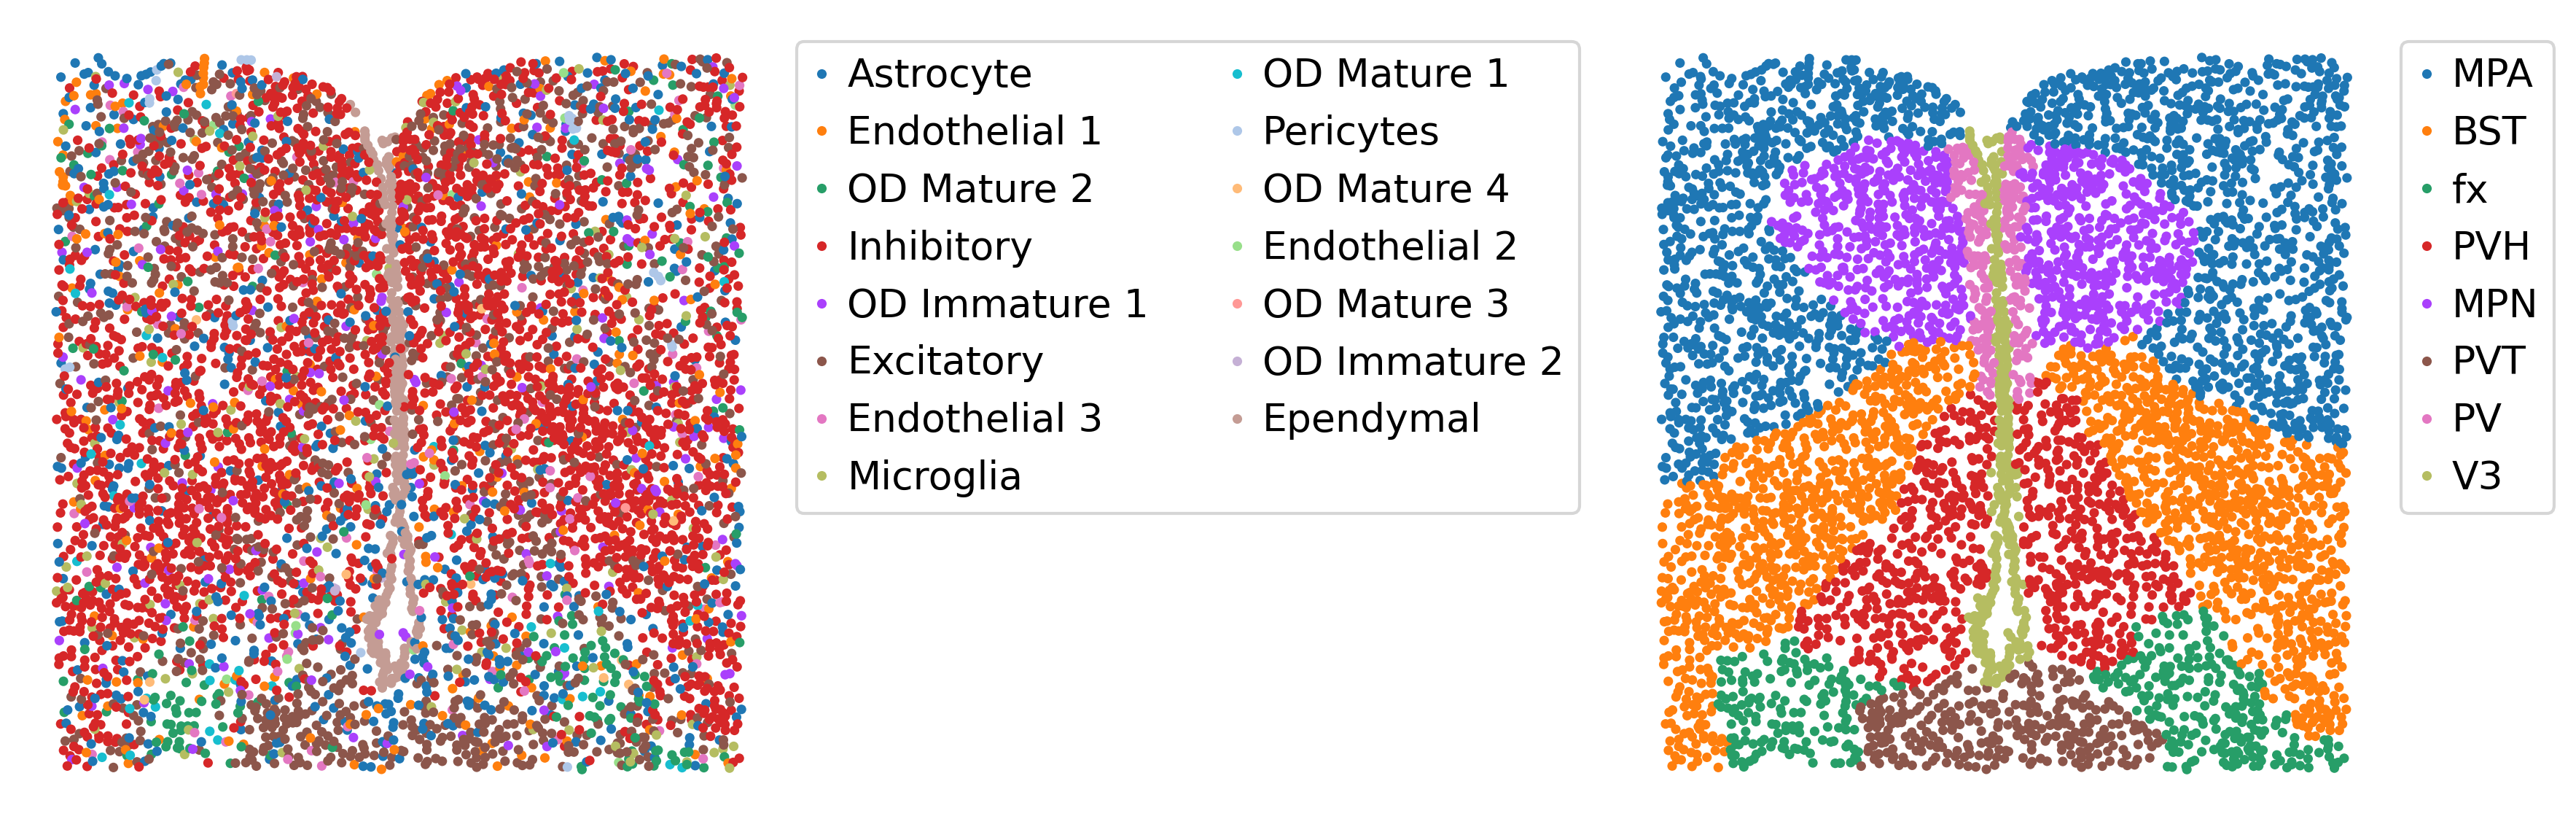

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi=150)
seaborn.scatterplot(x=spatial_coords.x, y=-spatial_coords.y, hue=true_celltypes, s=10, linewidth=0, ax=axes[0])
axes[0].legend(loc='upper left', bbox_to_anchor=(1,1), ncols=2)
axes[0].axis('off')

seaborn.scatterplot(x=spatial_coords.x, y=-spatial_coords.y, hue=true_domains, s=10, linewidth=0, ax=axes[1])
axes[1].legend(loc='upper left', bbox_to_anchor=(1,1))
axes[1].axis('off')

fig.tight_layout()
fig.show()

In [7]:
# after
import pandas as pd
import numpy as np

barcodes = pd.read_csv(f'mouse_hypothalamic/3d_merfish_data/_0_14_barcodes.csv', header = 0, index_col=0)
coords = barcodes['x'].str.split("x", expand=True).astype(int)
coords.columns = ['Centroid_X', 'Centroid_Y']
pos = coords.values  # shape: (n_cells, 2)

index=-0.14
raw = pd.read_csv(f'mouse_hypothalamic/3d_merfish_data/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv')
raw_ = raw[raw['Bregma'] == index]
raw_['x_int'] = raw_['Centroid_X'].round().astype(int)
raw_['y_int'] = raw_['Centroid_Y'].round().astype(int)
coord_to_info = (
    raw_.drop_duplicates(subset=['x_int','y_int'])
        .set_index(['x_int','y_int'])[['Cell_class', 'Neuron_cluster_ID']]
        .to_dict(orient='index')
)

cell_types_obs = []
for x, y in pos:
    info = coord_to_info.get((int(x), int(y)))
    if info is None:
        cell_types_obs.append(None)
    else:
        cls = info['Cell_class']
        if cls in ('Inhibitory', 'Excitatory'):
            cell_types_obs.append(info['Neuron_cluster_ID'])
        else:
            cell_types_obs.append(cls)

cell_types_obs = np.array(cell_types_obs, dtype=object)
true_celltypes = cell_types_obs

/tmp/ipykernel_1208051/3860003938.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_['x_int'] = raw_['Centroid_X'].round().astype(int)
/tmp/ipykernel_1208051/3860003938.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_['y_int'] = raw_['Centroid_Y'].round().astype(int)


/tmp/ipykernel_1208051/1460419775.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


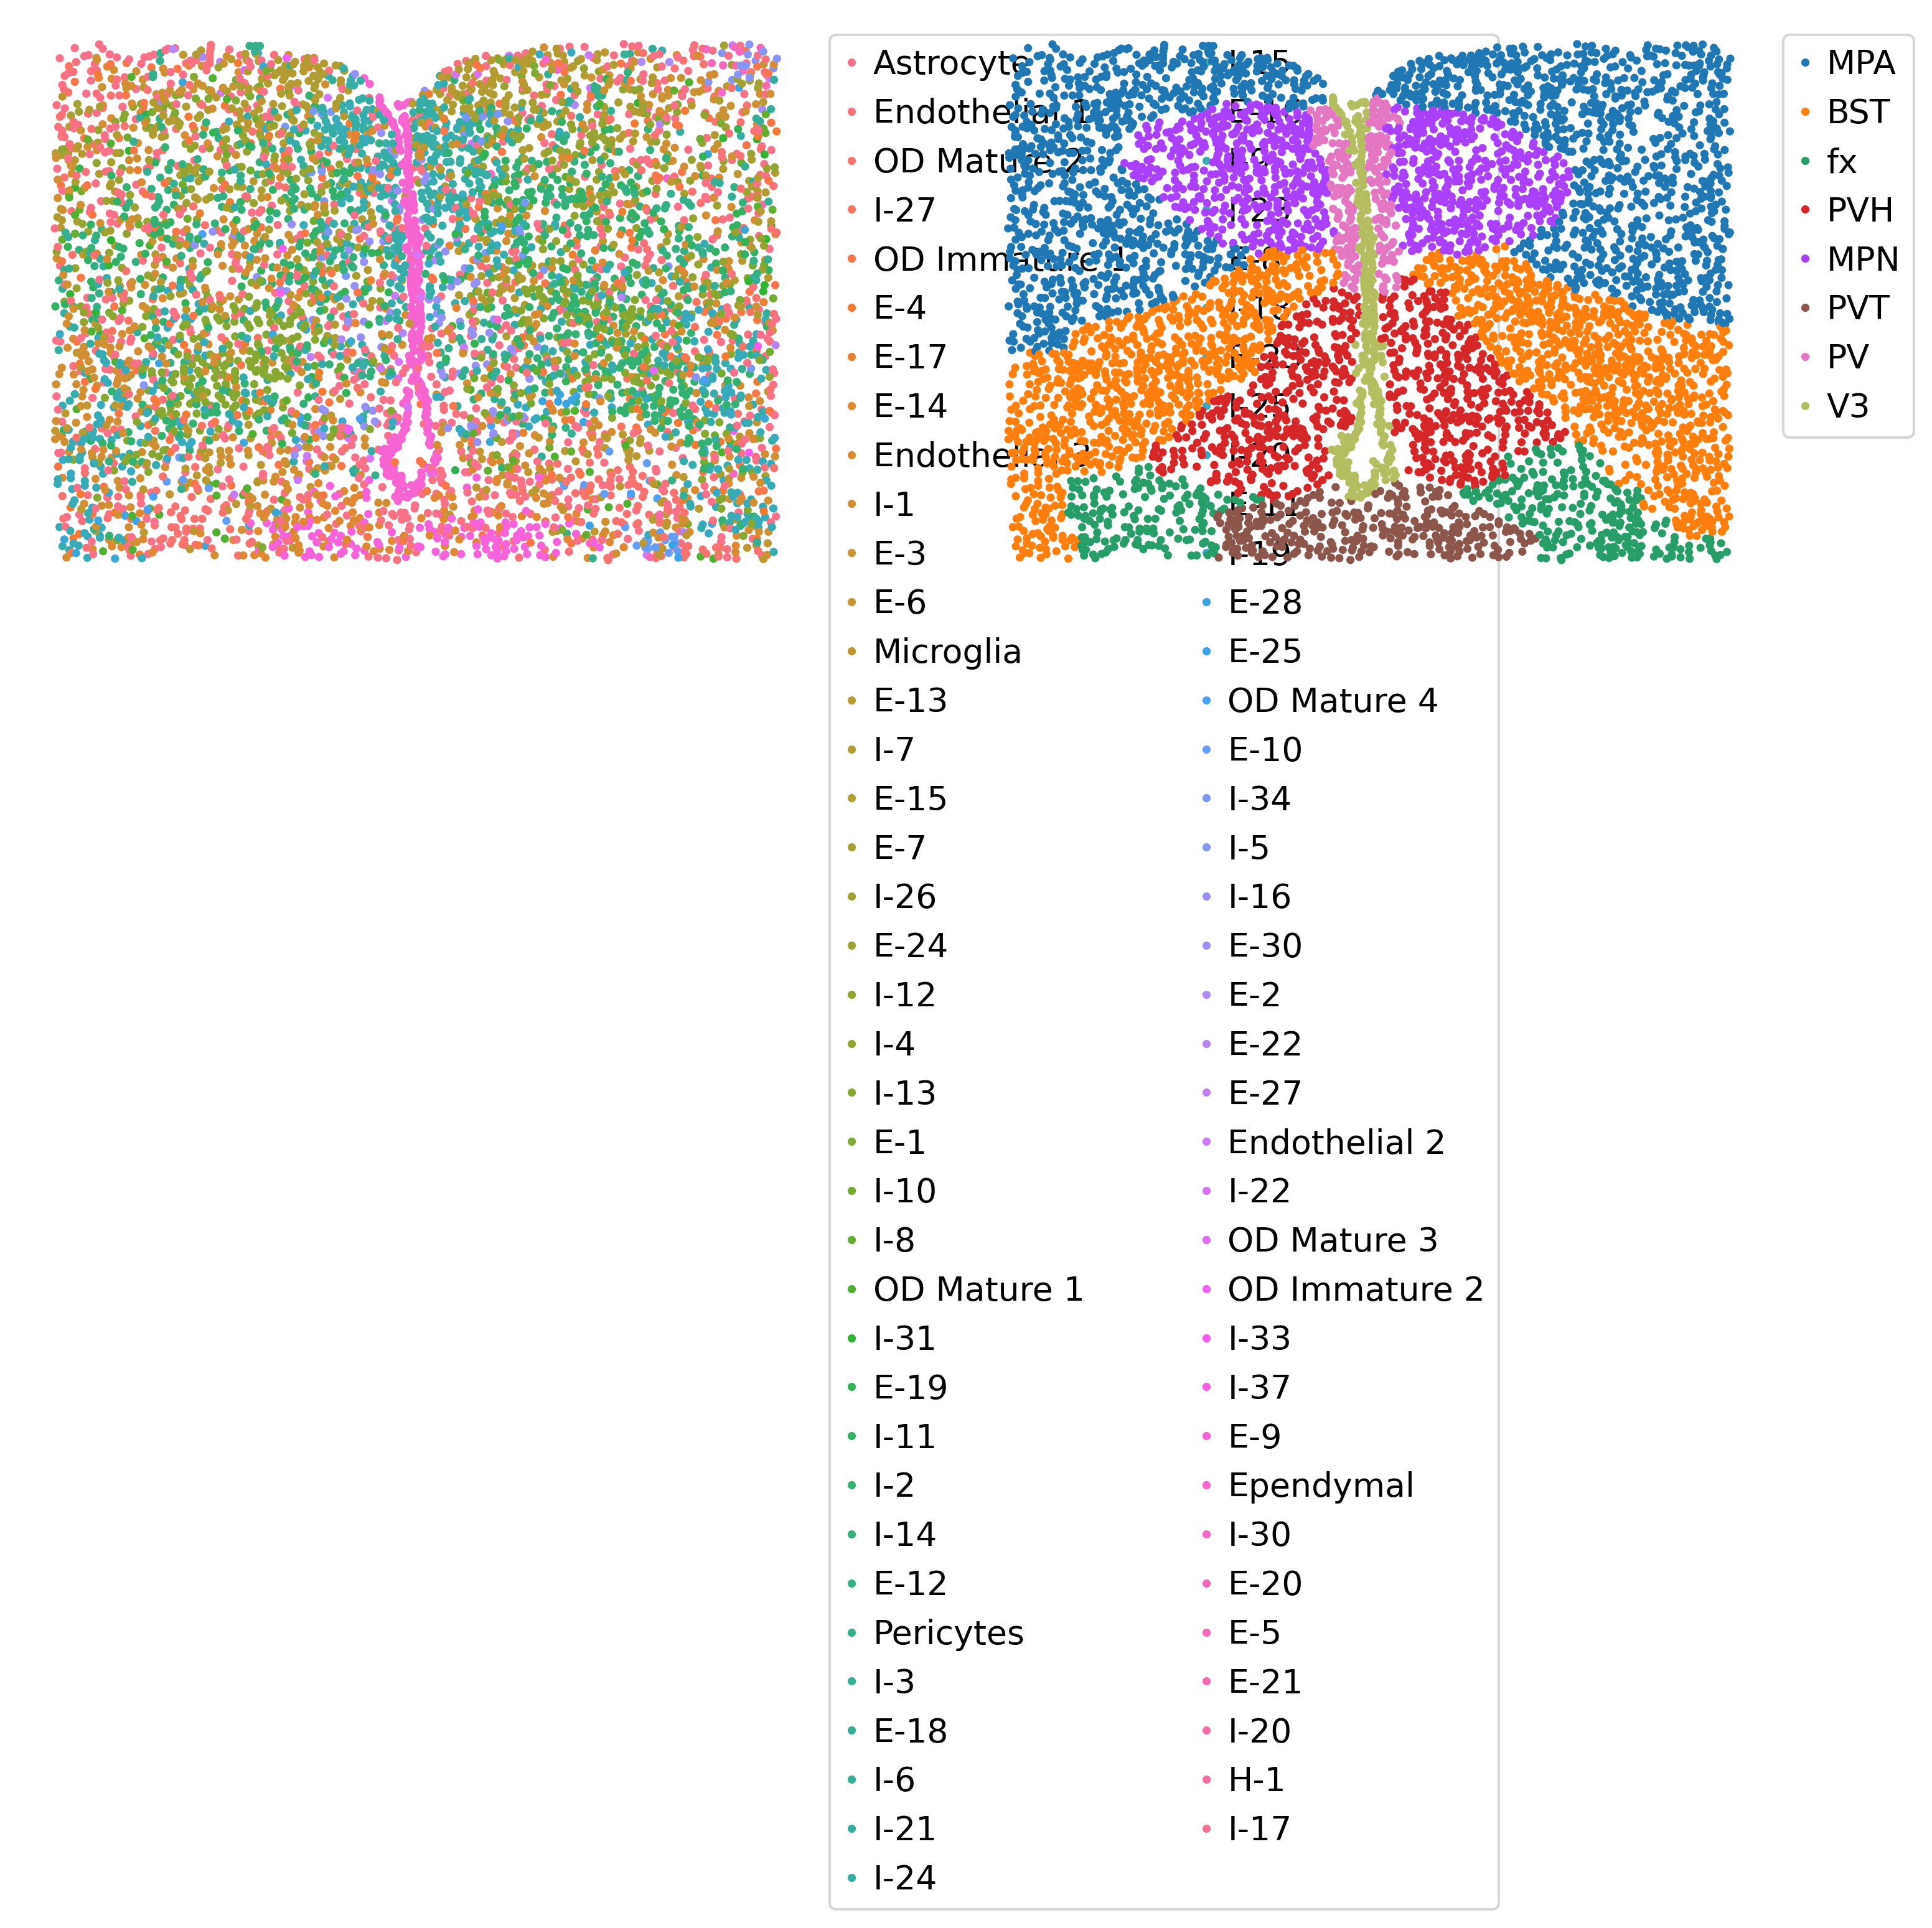

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi=150)
seaborn.scatterplot(x=spatial_coords.x, y=-spatial_coords.y, hue=true_celltypes, s=10, linewidth=0, ax=axes[0])
axes[0].legend(loc='upper left', bbox_to_anchor=(1,1), ncols=2)
axes[0].axis('off')

seaborn.scatterplot(x=spatial_coords.x, y=-spatial_coords.y, hue=true_domains, s=10, linewidth=0, ax=axes[1])
axes[1].legend(loc='upper left', bbox_to_anchor=(1,1))
axes[1].axis('off')

fig.tight_layout()
fig.show()

In [9]:
data = load_data_deprecated(X, adjacency)

In [10]:
dataloader = NeighborLoader( #NEW
    data,
    input_nodes=torch.arange(data.num_nodes), # [0, 1, 2, ..., n_obs-1]
    num_neighbors=[10,5],                     # Node sampling for each GNN layer
    batch_size=2048,                          # Number of center nodes for each batch
    shuffle=True
)

/home/jeongbinpark/miniconda3/envs/minibatch/lib/python3.10/site-packages/torch_geometric/loader/neighbor_loader.py:229: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  neighbor_sampler = NeighborSampler(


In [11]:
# edge_index2: consider 2-hop reachable node pairs to have edges
adjacency2 = adjacency @ adjacency
edge_index2 = np.vstack(adjacency2.nonzero())
edge_index2 = torch.tensor(edge_index2, dtype=torch.long)

# edge_index0: self-edges (0-hop) # I think VGAE automatically adds self-edges. But I don't know whether leaving edge_index0 as an empty tensor will cause problem or not.
edge_index0 = torch.tensor(np.vstack([np.arange(data.x.shape[0]), np.arange(data.x.shape[0])]))

/home/jeongbinpark/_Spatial_VGAE/Spatial_VGAE_prodLDA_final_all.py:242: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(z)                                                # mixture probability


Epoch 0 Loss: 215335.40625
Epoch 50 Loss: 149058.125
Epoch 100 Loss: 127280.25
Epoch 150 Loss: 113877.15625
Epoch 200 Loss: 102855.890625
Epoch 250 Loss: 95594.265625
Epoch 300 Loss: 92172.9140625
Epoch 350 Loss: 89889.90625
Epoch 400 Loss: 89111.9296875
Epoch 450 Loss: 88475.4921875
Epoch 500 Loss: 101260.3125
Epoch 550 Loss: 98255.078125
Epoch 600 Loss: 97137.75
Epoch 650 Loss: 97023.671875
Epoch 700 Loss: 96972.3203125
Epoch 750 Loss: 96859.90625
Epoch 800 Loss: 96849.90625
Epoch 850 Loss: 97104.953125
Epoch 900 Loss: 97052.7578125
Epoch 950 Loss: 97037.1484375
Epoch 1000 Loss: 102910.9296875
Epoch 1050 Loss: 99875.15625
Epoch 1100 Loss: 100706.0234375
Epoch 1150 Loss: 100569.125
Epoch 1200 Loss: 100075.8125
Epoch 1250 Loss: 100099.1171875
Epoch 1300 Loss: 99804.796875
Epoch 1350 Loss: 99672.03125
Epoch 1400 Loss: 100235.0
Epoch 1450 Loss: 100225.09375
Epoch 1500 Loss: 101335.2578125
Epoch 1550 Loss: 100170.5
Epoch 1600 Loss: 100782.96875
Epoch 1650 Loss: 102236.84375
Epoch 1700 Los

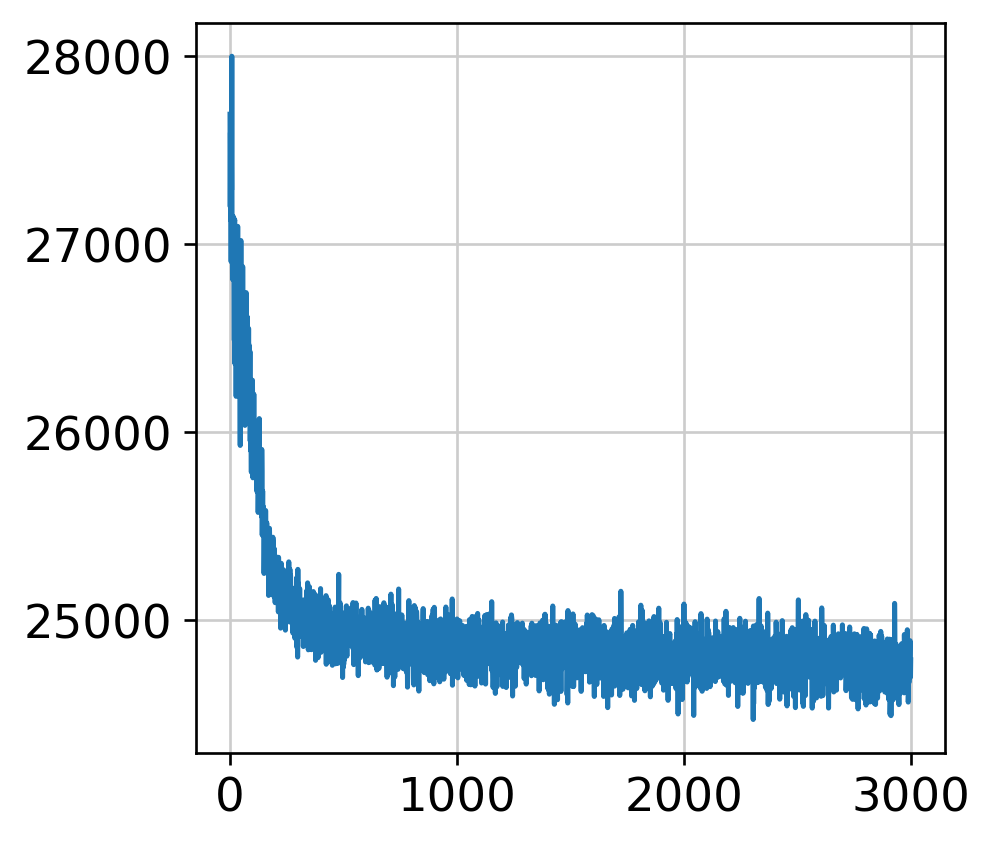

In [12]:
pyg.seed_everything(1)

hid_dim = 128
num_topics = 16
n_celltypes= 20
temperature=1.0

model = VGAE(ProdLDAEncoder(data.num_features, hid_dim, num_topics))
model_ct = VAE(data.num_features, hid_dim, 1, num_categories=n_celltypes)
model_ff = FFPredict(num_topics, n_celltypes)

[model, model_ct, model_ff], device, loss_values = train(data, model, model_ct, model_ff, temperature=0.3, early_stopping=False, alpha=1,
                                                         wloss_spatial=0.8, wloss_KLD=0.005, wloss_recon=1, wloss_entropy=2.0, #0.8,
                                                         grad_clip=100, l1_ratio=0, lr=9e-3, epochs=3000)#, edge_index0=edge_index0, edge_index2=edge_index2) 

[model, model_ct, model_ff], device, loss_values = train_concat(data, model, model_ct, model_ff, temperature=0.3, early_stopping=False, alpha=1,
                                                         wloss_spatial=0.8, wloss_KLD=0.005, wloss_recon=1, wloss_entropy=0.8, #wloss_entropy=0.5, wtanh=-200, 
                                                         grad_clip=100, l1_ratio=0, lr=9e-3, epochs=3000)

'''
[model, model_ct, model_ff], device, loss_values = train_batch(dataloader, model, model_ct, model_ff, temperature=0.3, early_stopping=False, alpha=1,
                                                         wloss_spatial=0.8, wloss_KLD=0.005, wloss_recon=1, wloss_entropy=2.0, #0.8,
                                                         grad_clip=100, l1_ratio=0, lr=9e-3, epochs=600)#, edge_index0=edge_index0, edge_index2=edge_index2) 

[model, model_ct, model_ff], device, loss_values = train_batch_concat(dataloader, model, model_ct, model_ff, temperature=0.3, early_stopping=False, alpha=1,
                                                         wloss_spatial=0.8, wloss_KLD=0.005, wloss_recon=1, wloss_entropy=0.8, #wloss_entropy=0.5, wtanh=-200, 
                                                         grad_clip=100, l1_ratio=0, lr=9e-3, epochs=600)
'''

plt.plot(loss_values)
plt.show()


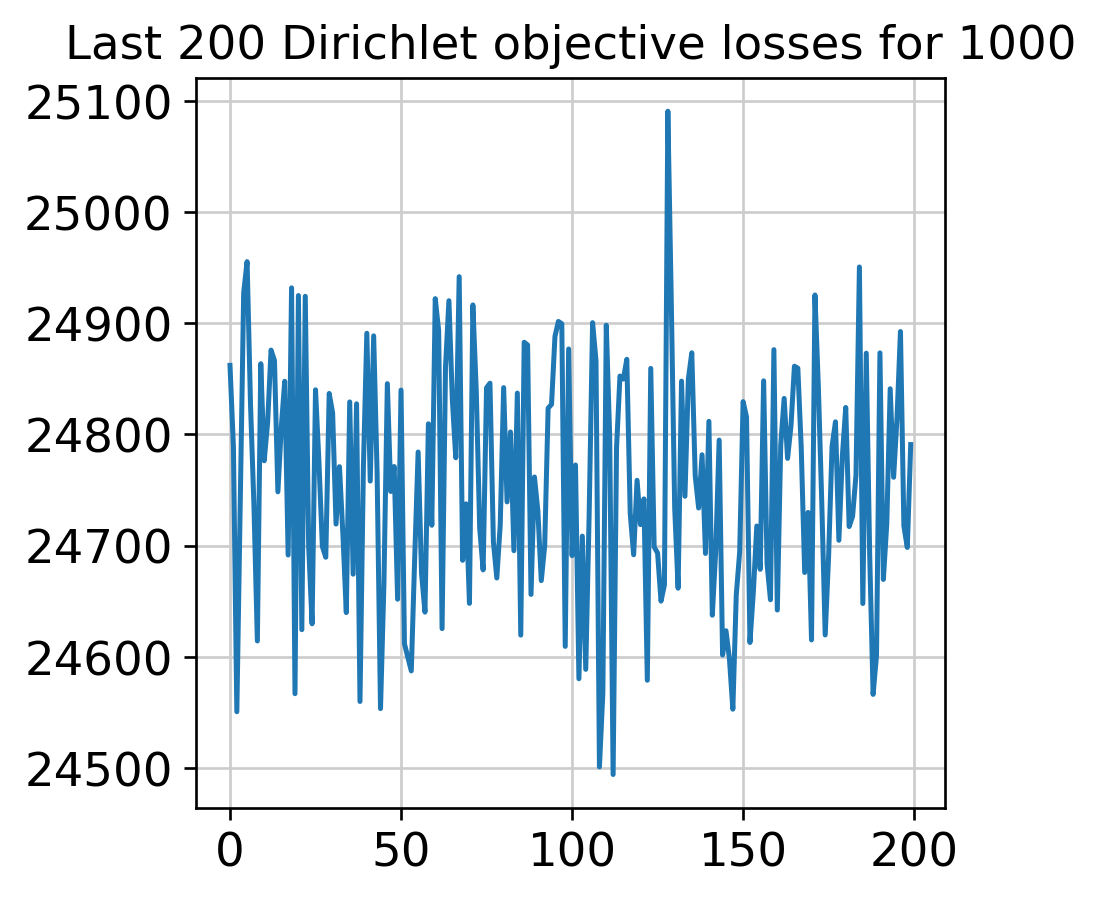

In [13]:
plt.title("Last 200 Dirichlet objective losses for 1000")
plt.plot(loss_values[-200:])
plt.show()

/tmp/ipykernel_1208051/3015866325.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  recon = F.softmax(model_ff(p))             # reconstructed distribution over vocabulary


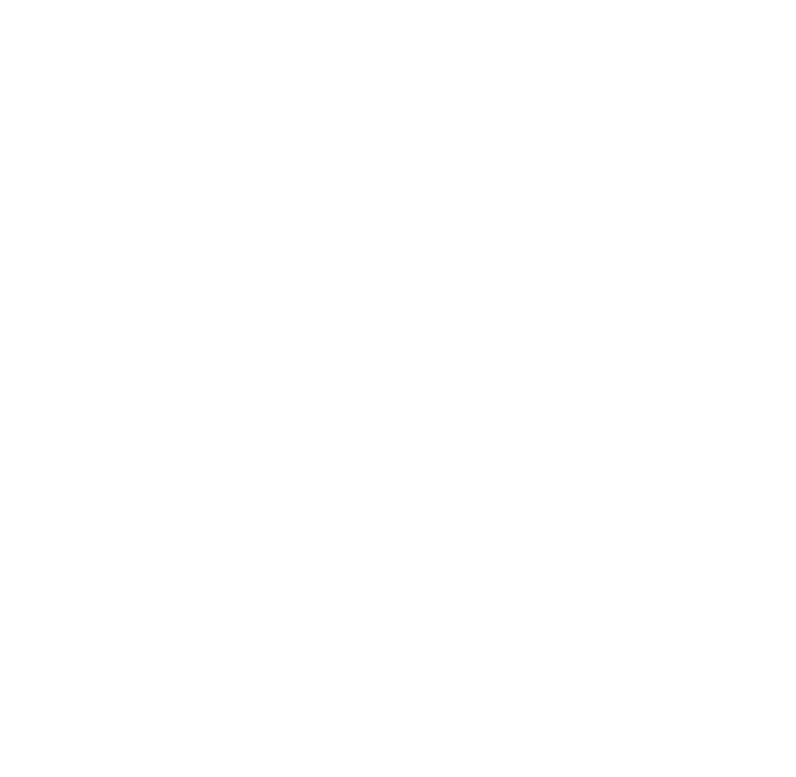

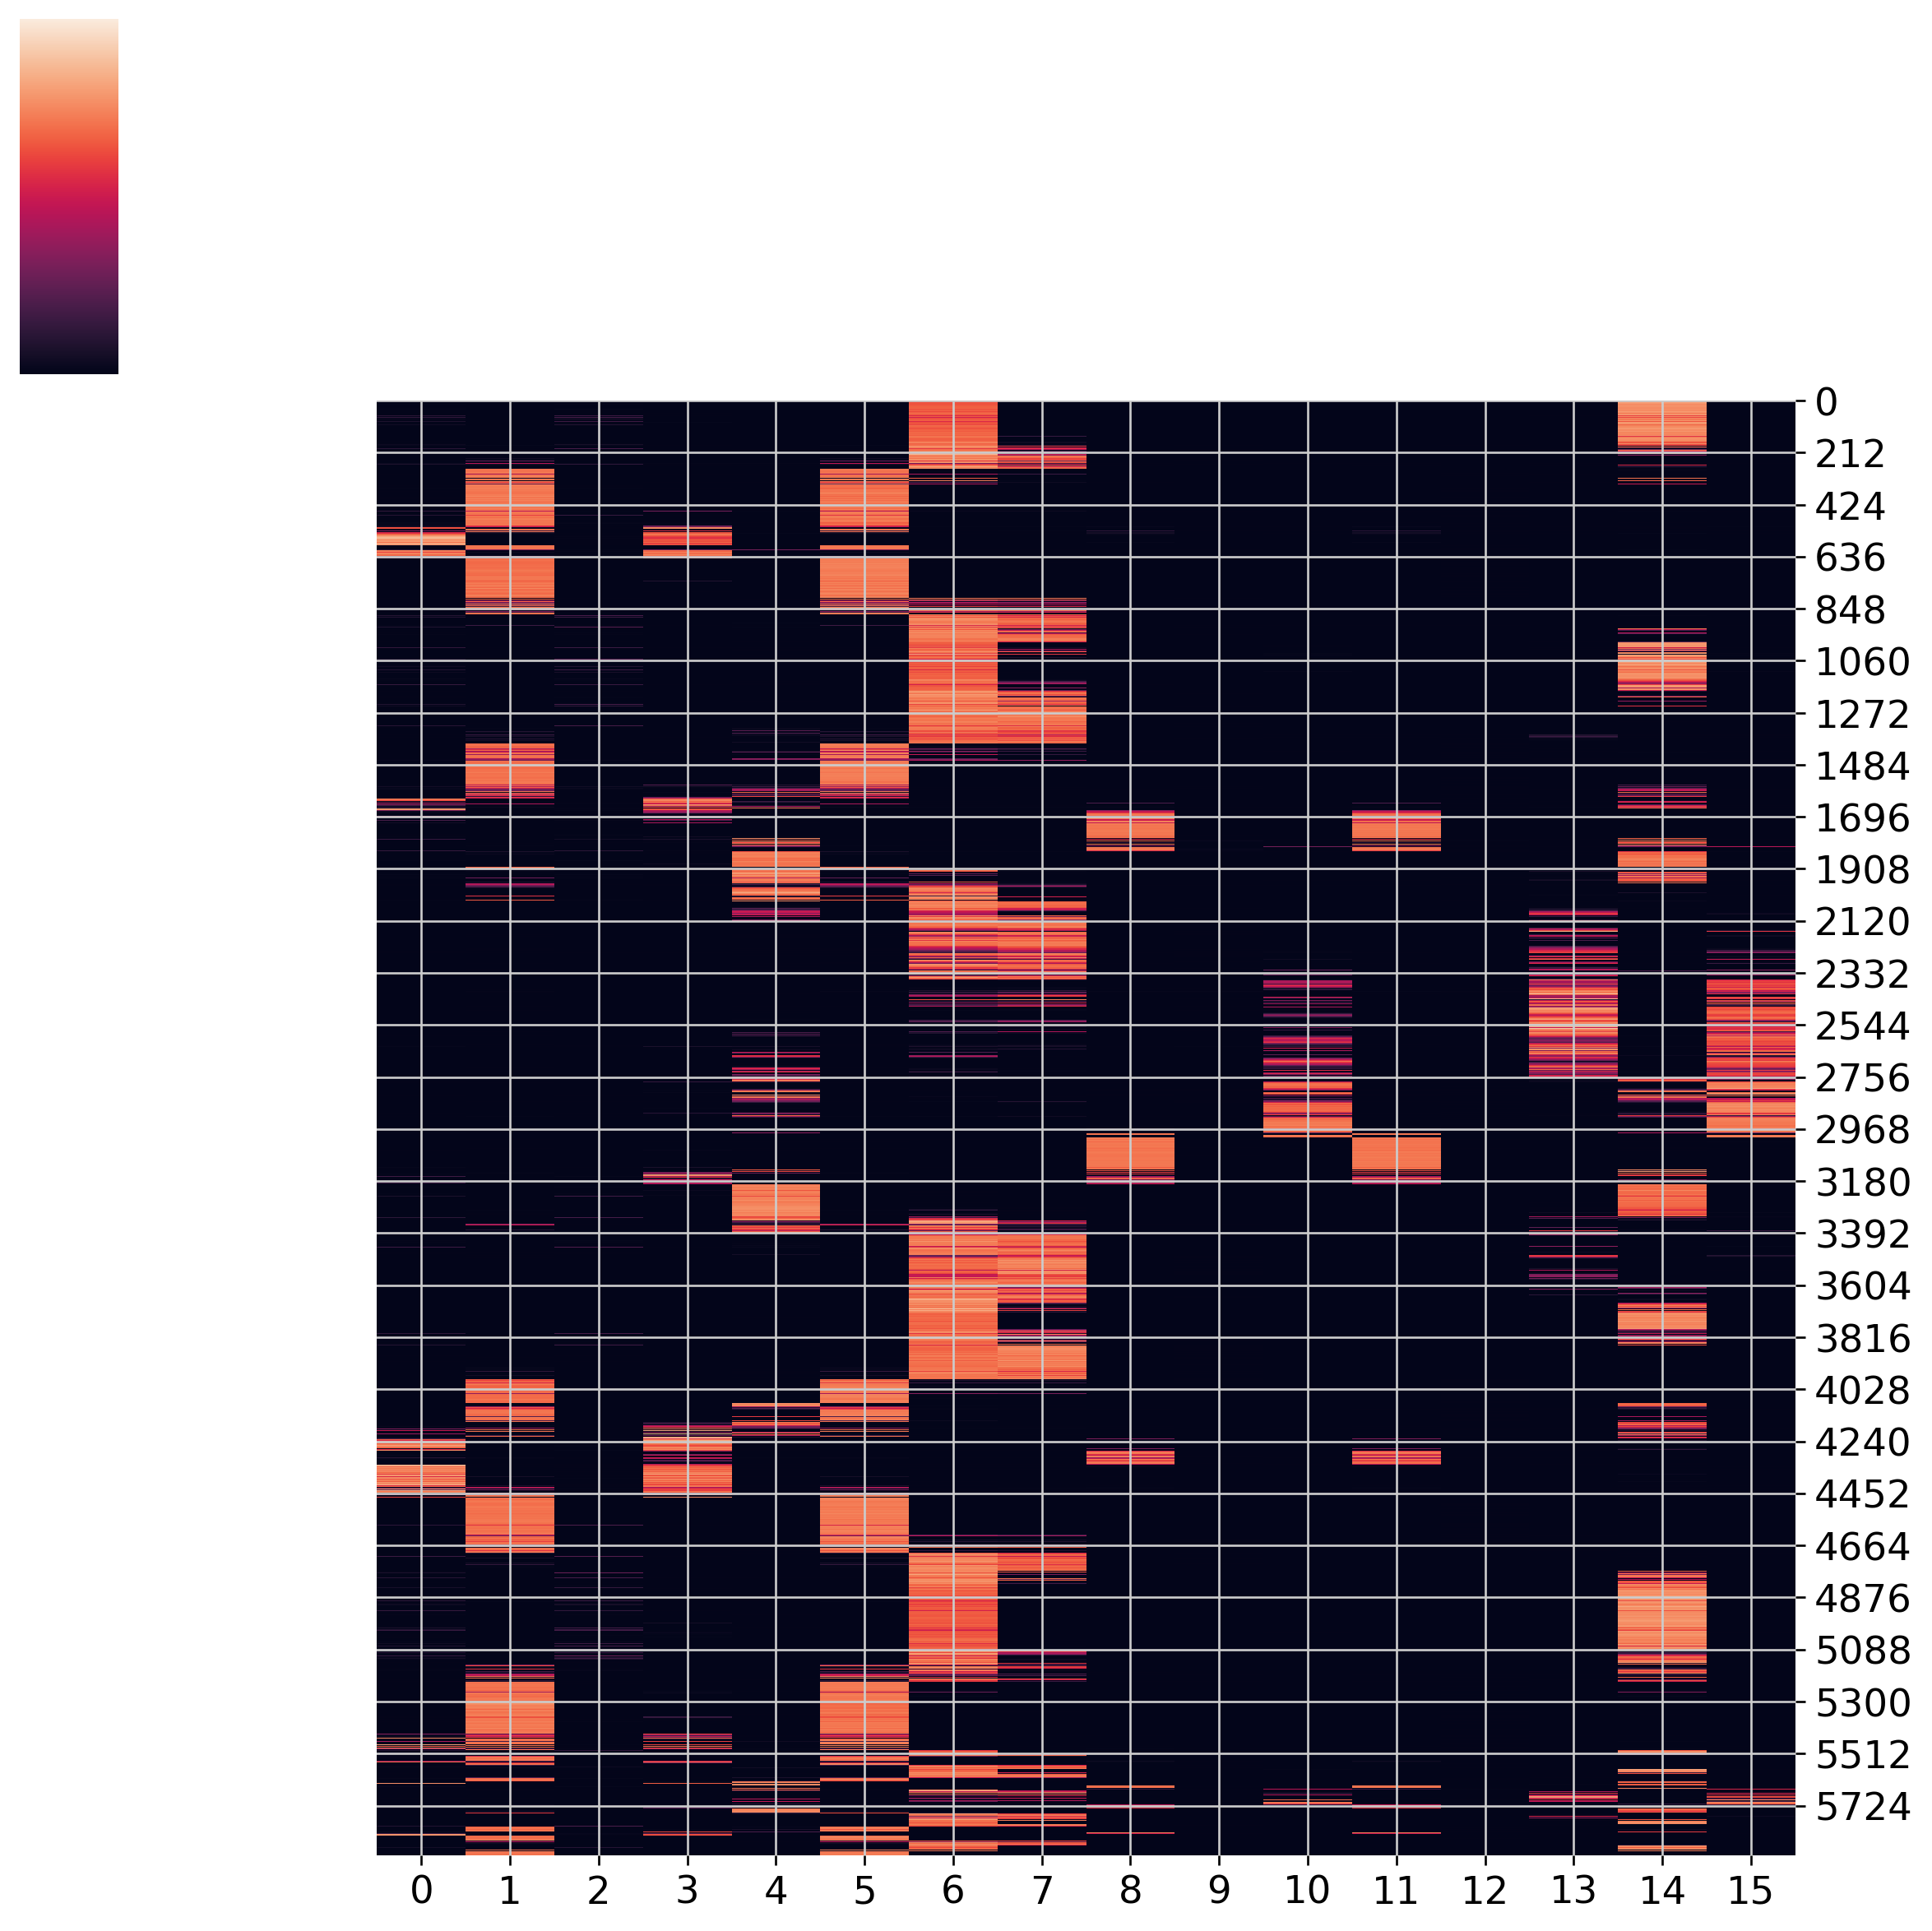

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model_ff = model_ff.to(device)
model_ct = model_ct.to(device)
edge_index0 = edge_index0.to(device)
edge_index2 = edge_index2.to(device)
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)

'''
model.eval()
with torch.no_grad():
    #z, p, posterior_mean, posterior_logvar, posterior_var = model.encoder(data.x, data.edge_index, edge_index0, edge_index2)
    z, p, posterior_mean, posterior_logvar, posterior_var = model.encoder(data.x, data.edge_index)
    recon = F.softmax(model_ff(p))             # reconstructed distribution over vocabulary
'''
model.eval()
with torch.no_grad():
    n_samples = 50
    p_mat = []
    with torch.no_grad():
        for r in range(n_samples):
            z, p, posterior_mean, posterior_logvar, posterior_var = model.encoder(data.x, data.edge_index)
            p_mat.append(p)

    p = torch.stack(p_mat, dim=0).mean(dim=0)
    #z, p, posterior_mean, posterior_logvar, posterior_var = model.encoder(data.x, data.edge_index)
    recon = F.softmax(model_ff(p))             # reconstructed distribution over vocabulary

plt.axis(False)
seaborn.clustermap( p.detach().cpu().numpy(), row_cluster=False, col_cluster=False)
plt.axis(False)
plt.show()

In [15]:
recon_celltype = model_ff(p)                                              # logits: (N, n_classes)
cell_types_obs1 = recon_celltype.argmax(dim=1).cpu().numpy().astype(str)  # sc.pl.dotplot handles string label better

recon_x, logits, _ = model_ct(data.x.to(device), temperature=temperature)
logits = logits.squeeze(1)
cell_types_obs2 = F.softmax(logits, dim=1).argmax(dim=1).cpu().numpy().astype(str)

cell_types_obs = true_celltypes

Predicted  Astrocyte  E-1  E-10  E-11  E-12  E-13  E-14  E-15  E-16  E-17  \
Observed                                                                    
2                 33    0     0     0     0     0     0     0     0     0   
4                257   29     0     7    20     9     5    23    16    12   
5                 72    2     0     1     1     6    87     0     0     0   
10                11    1     0     0     0     1     0     0     2     0   
11                44    0    23     2     0    34     8     0     0     0   
12               134    1     0     2    15    12     4     1    33     3   
17                93    0     0     1    99     2     0    64     8    32   
18                24    0     0     1     2     1     0    12     0    10   

Predicted  ...  I-8  I-9  Microglia  OD Immature 1  OD Immature 2  \
Observed   ...                                                      
2          ...    0    0          3              8              1   
4          ...   22   

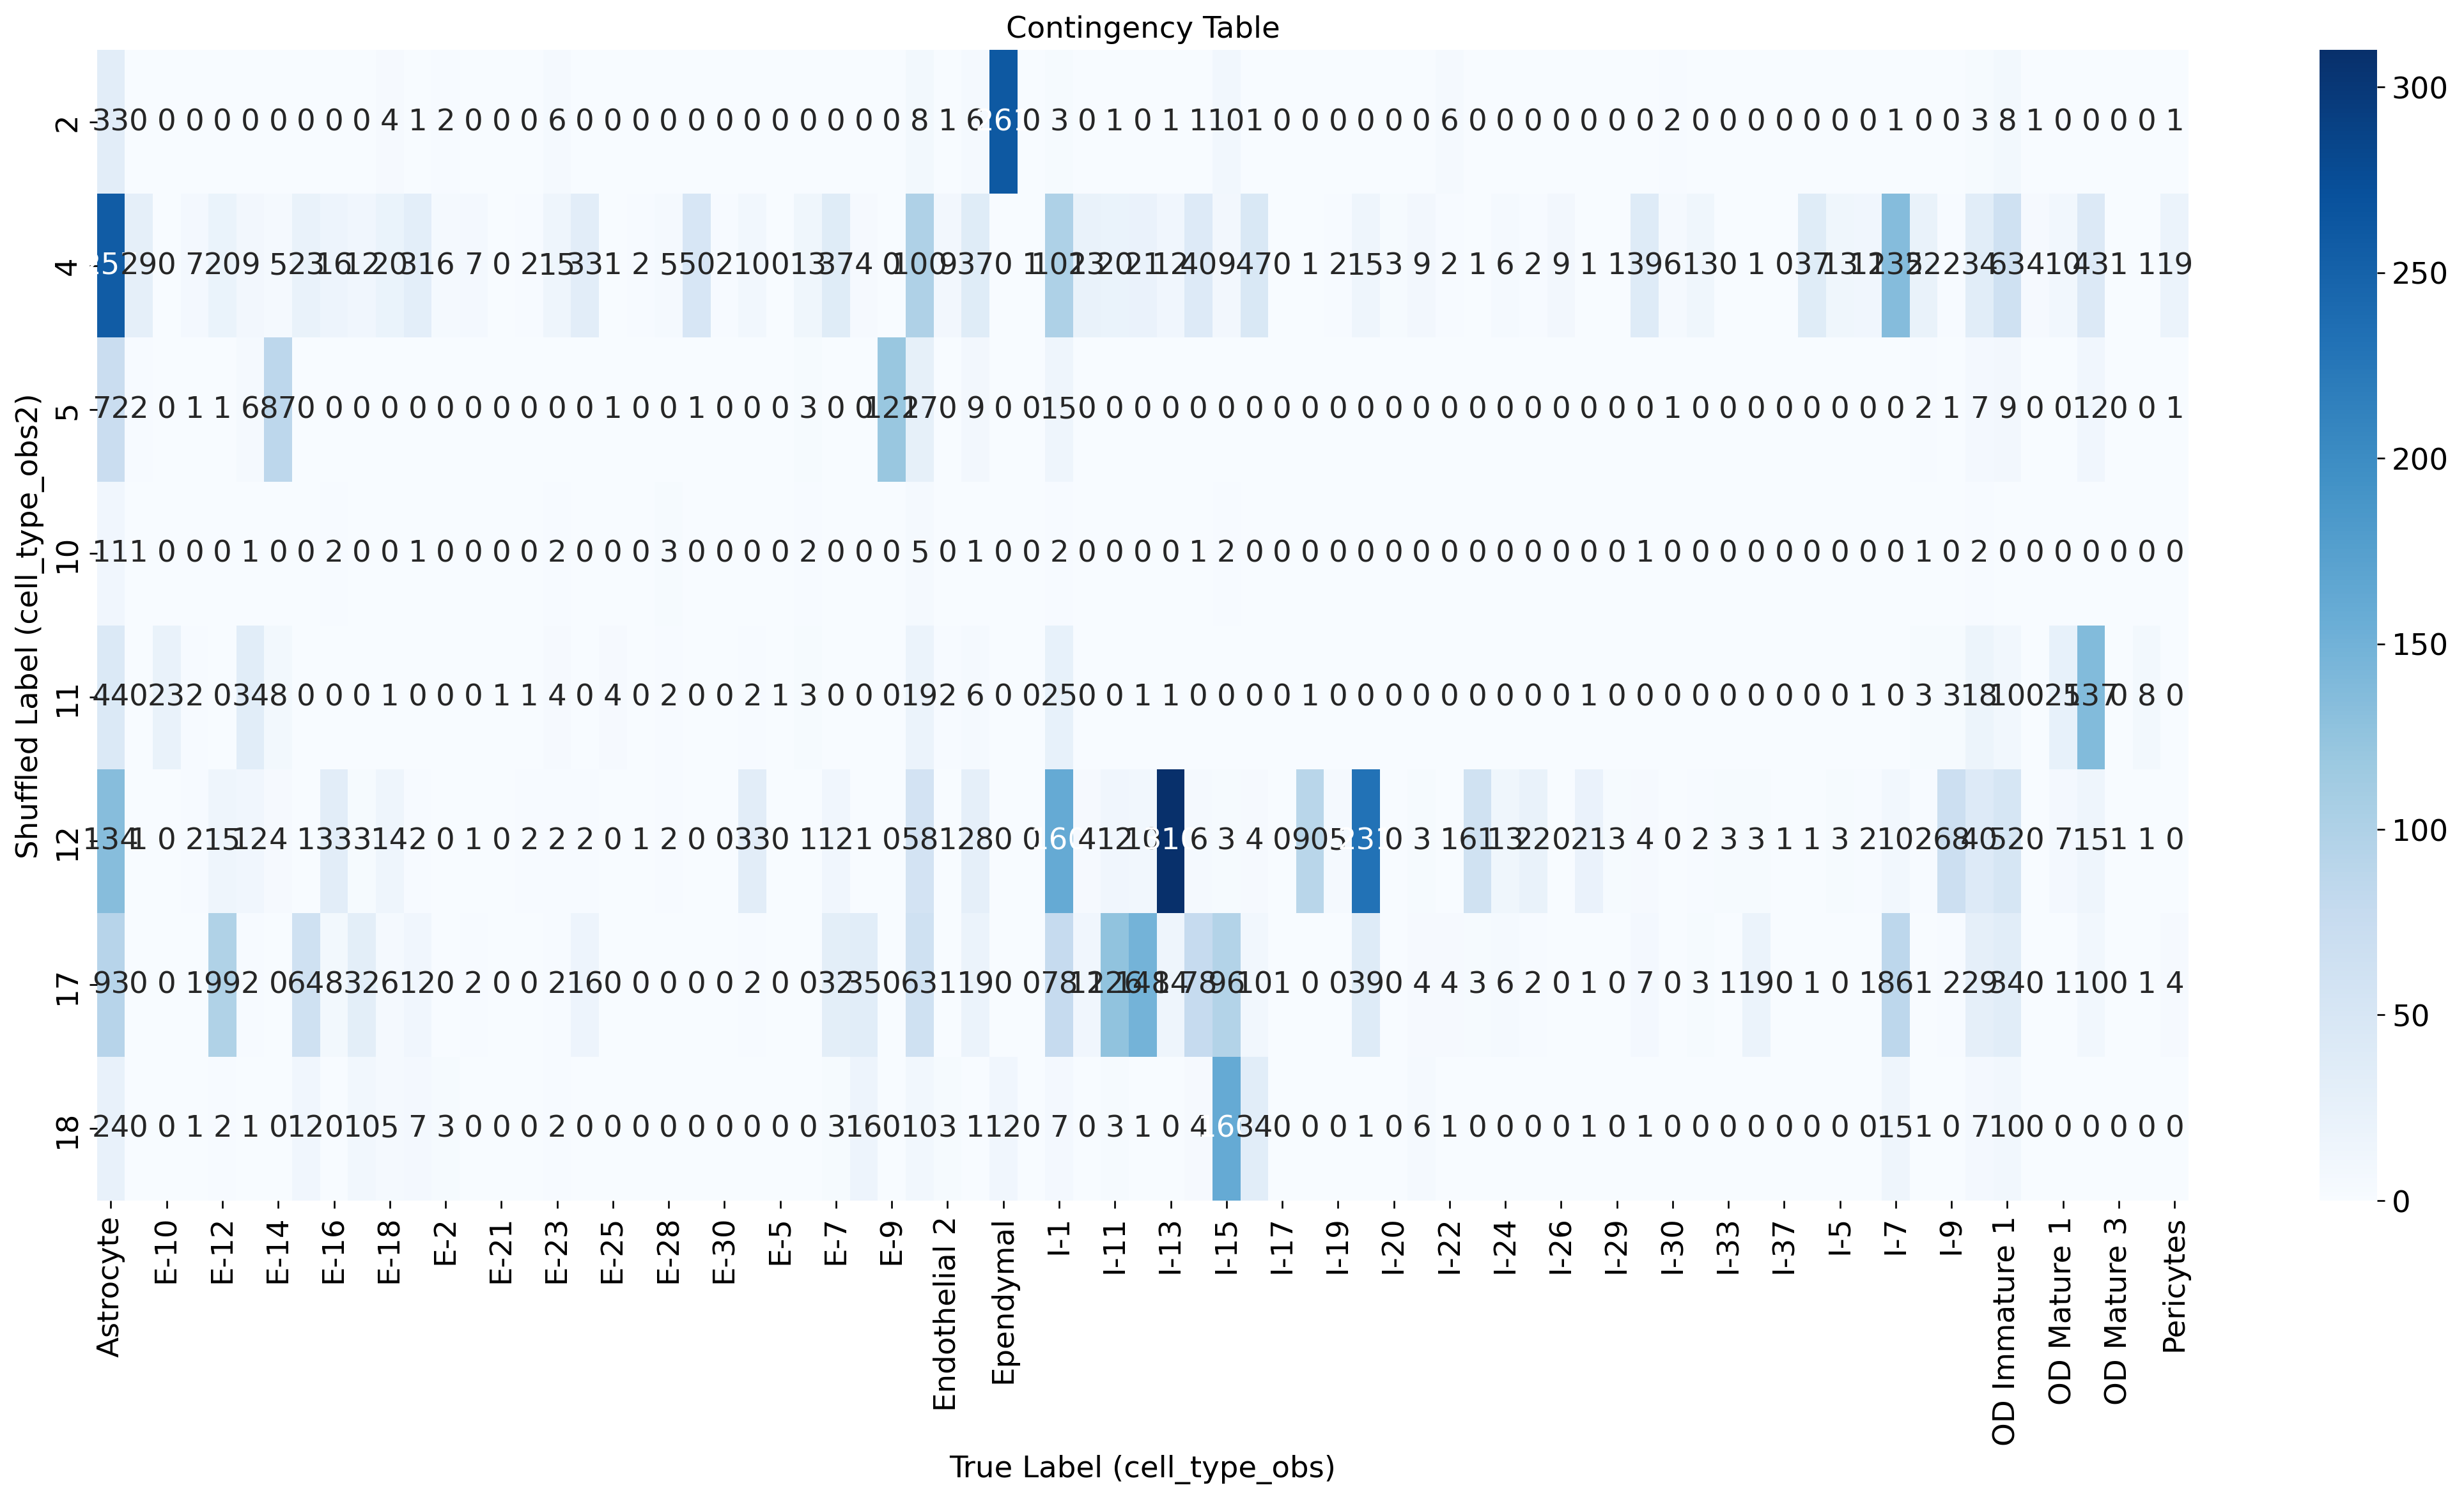

In [16]:
import pandas as pd

# Converting to Series
obs_series = pd.Series(cell_types_obs1.astype(int), name="Observed")
pred_series = pd.Series(cell_types_obs, name="Predicted")

# Create Cross Table
contingency_table = pd.crosstab(index=obs_series, columns=pred_series)
sorted_index = sorted(contingency_table.index, key=lambda x: int(x))
contingency_table = contingency_table.loc[sorted_index]

# Output 
print(contingency_table)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
sns.heatmap(contingency_table, cmap="Blues", annot=True, fmt="d")
plt.title("Contingency Table")
plt.xlabel("True Label (cell_type_obs)")
plt.ylabel("Shuffled Label (cell_type_obs2)")
plt.tight_layout()
plt.grid(False)
plt.show()


Predicted  Astrocyte  E-1  E-10  E-11  E-12  E-13  E-14  E-15  E-16  E-17  \
Observed                                                                    
0                  0    0     0     0     0     0     0     0     0     0   
1                  0    0     9     0     2     0     0     3     0     0   
2                  4    0     0     0     0     0     0     0     0     0   
3                  1    1     0     1     0    55     0     0     0     0   
4                  7   31     1     9    35     6    23    32    25    20   
5                  0    0     0     0     0     0    80     0     0     0   
6                  0    0     0     0     0     4     0     0    31     0   
7                  1    0     9     0     0     0     1     0     0     0   
8                  0    0     0     1     0     0     0     7     0     0   
9                  1    0     0     0     7     0     0     1     2     0   
10               644    0     1     0     0     0     0     0     0     0   

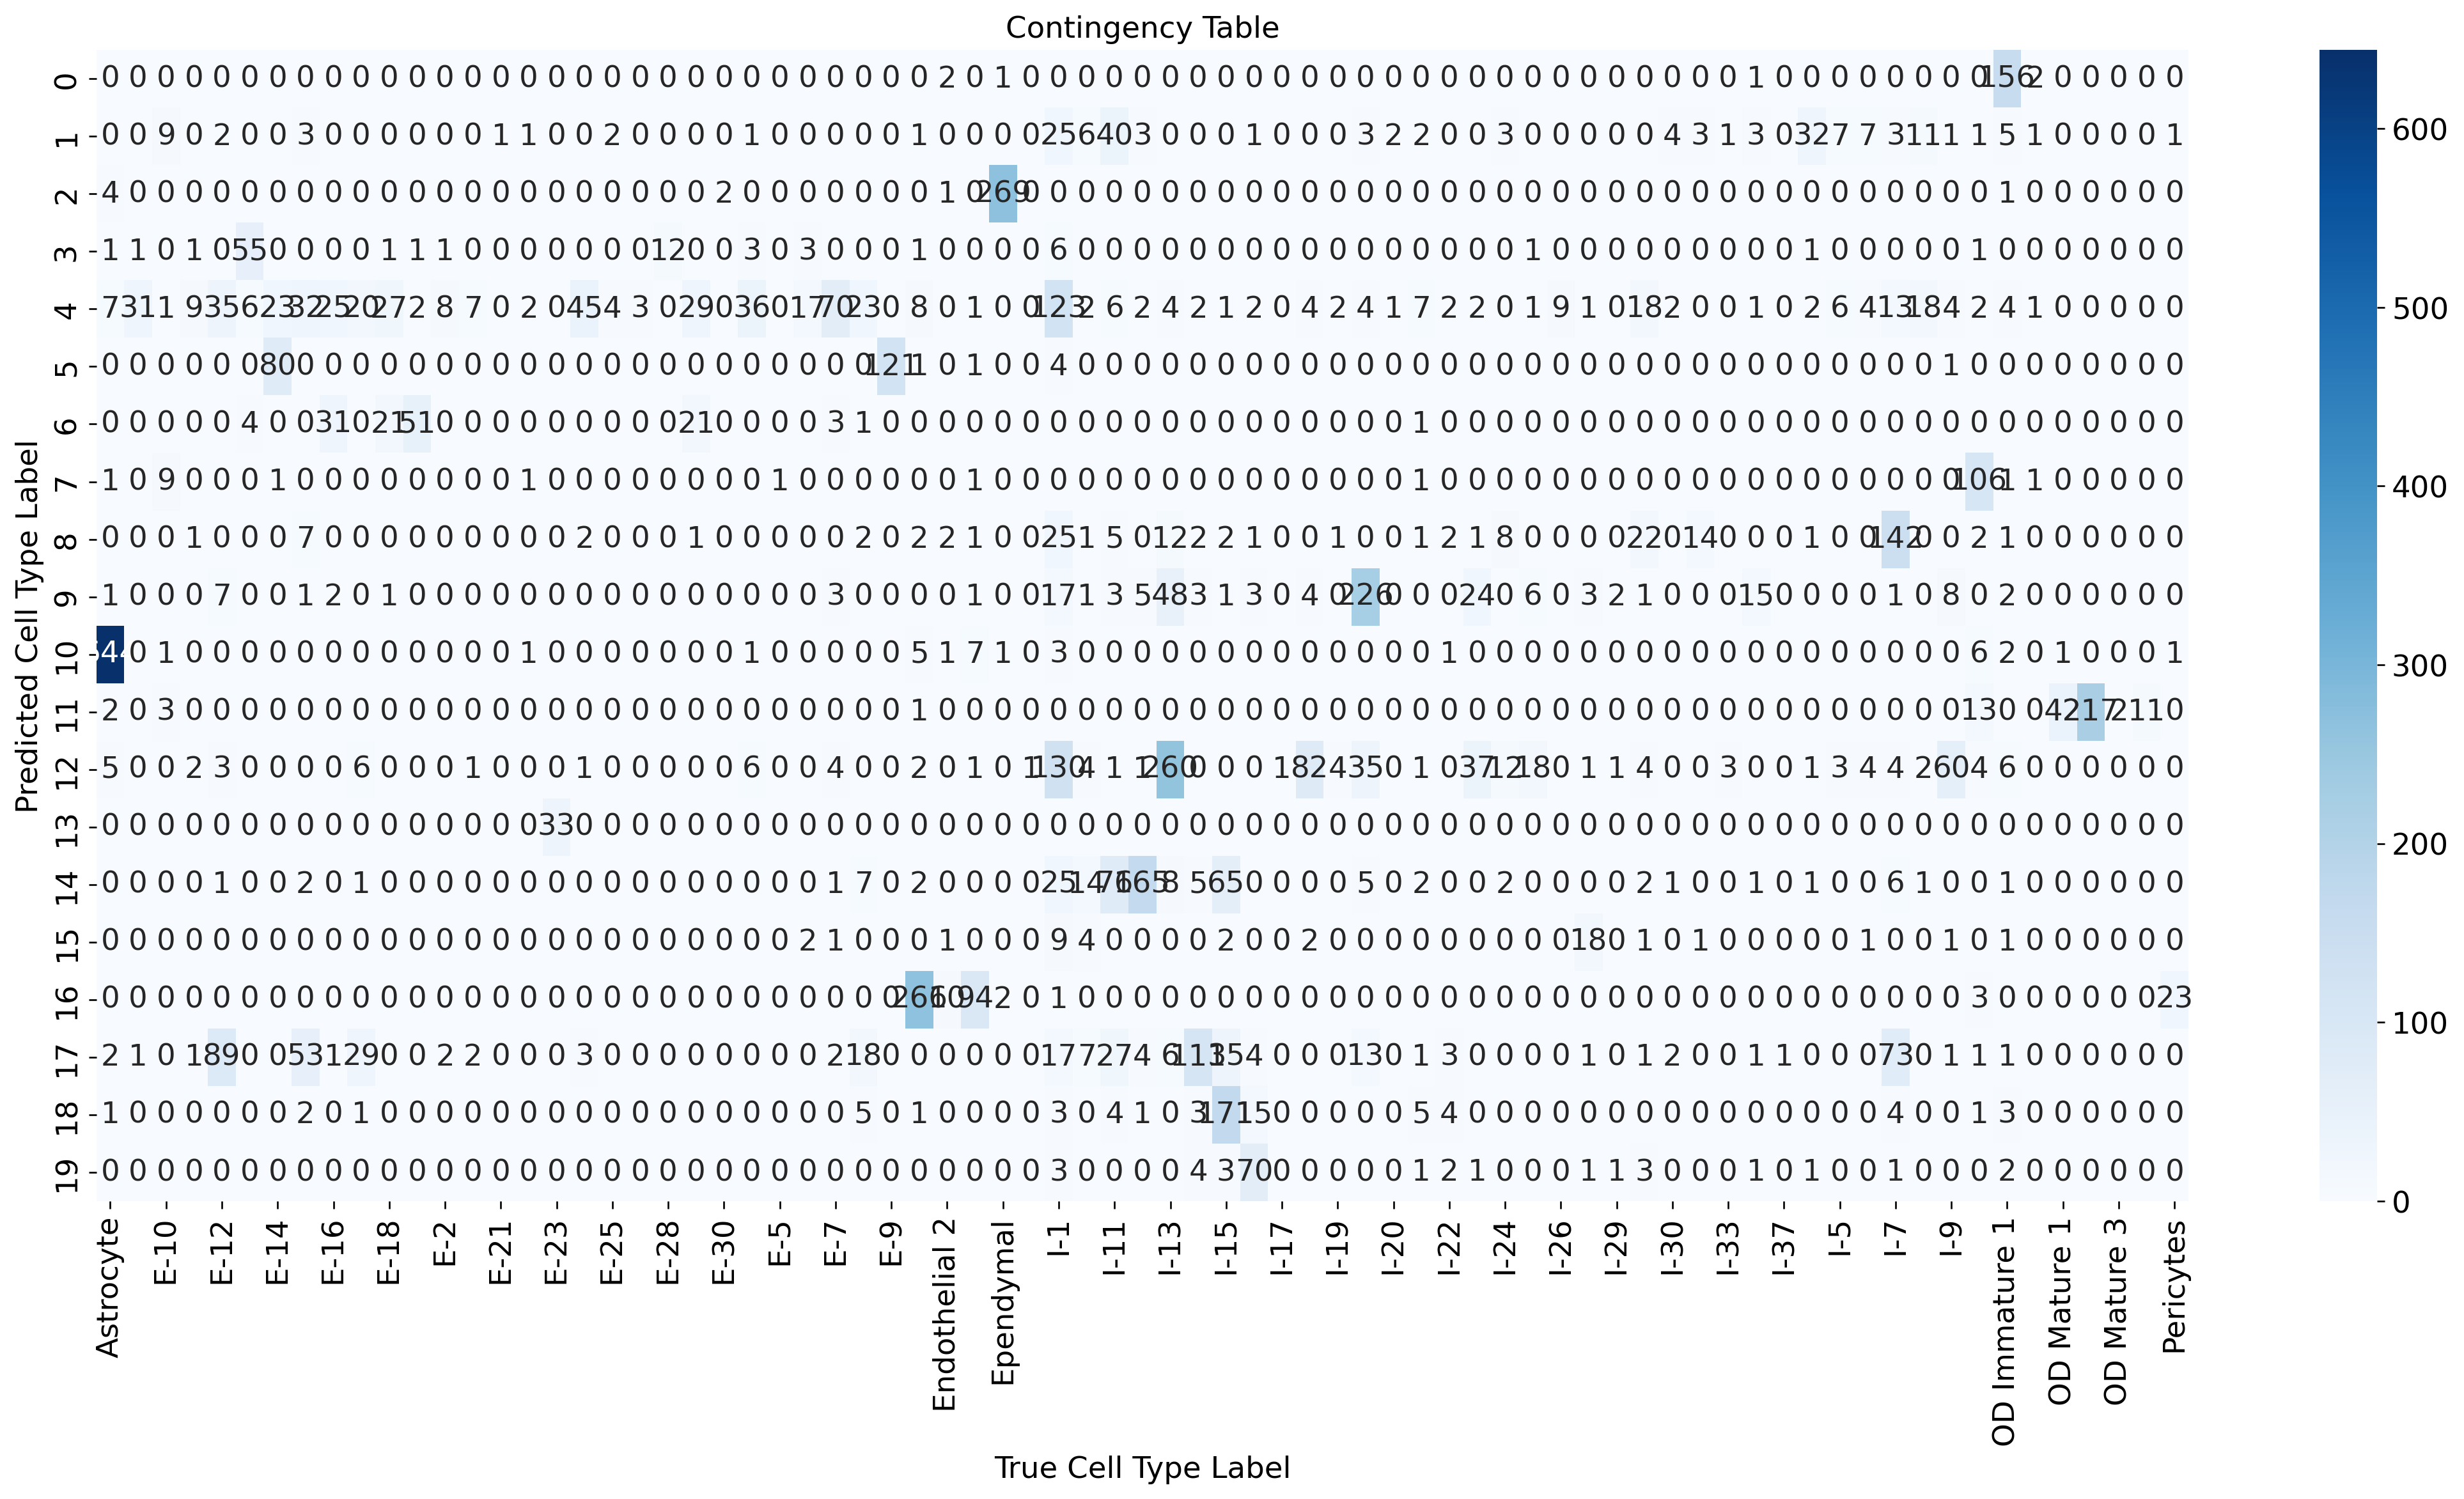

In [17]:
import pandas as pd

# Converting to Series
obs_series = pd.Series(cell_types_obs2.astype(int), name="Observed")
pred_series = pd.Series(cell_types_obs, name="Predicted")

# Create Cross Table
contingency_table = pd.crosstab(index=obs_series, columns=pred_series)
sorted_index = sorted(contingency_table.index, key=lambda x: int(x))
contingency_table = contingency_table.loc[sorted_index]

# Output 
print(contingency_table)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
sns.heatmap(contingency_table, cmap="Blues", annot=True, fmt="d")
plt.title("Contingency Table")
plt.xlabel("True Cell Type Label")
plt.ylabel("Predicted Cell Type Label")
plt.tight_layout()
plt.grid(False)
plt.show()


In [18]:
adjusted_rand_score(cell_types_obs2.astype(int), cell_types_obs)

0.46180822891498047

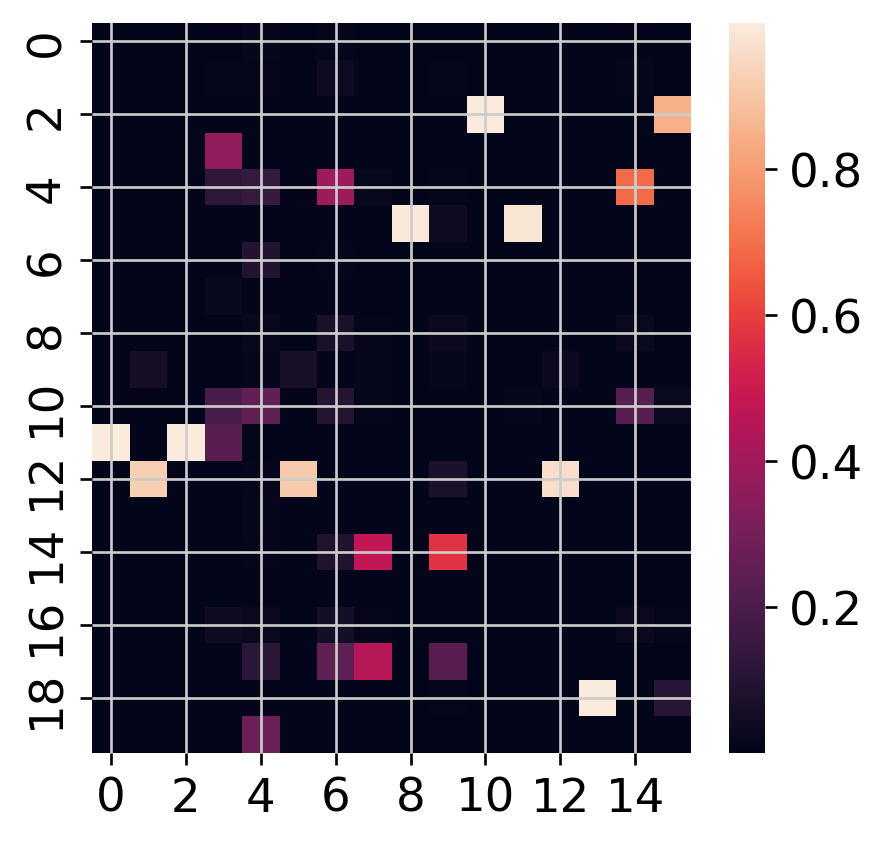

In [19]:
# plot cell type proportions per topic
seaborn.heatmap( F.softmax(model_ff.fc1.weight.detach().cpu(), dim=0).numpy() )
plt.show()

<Axes: >

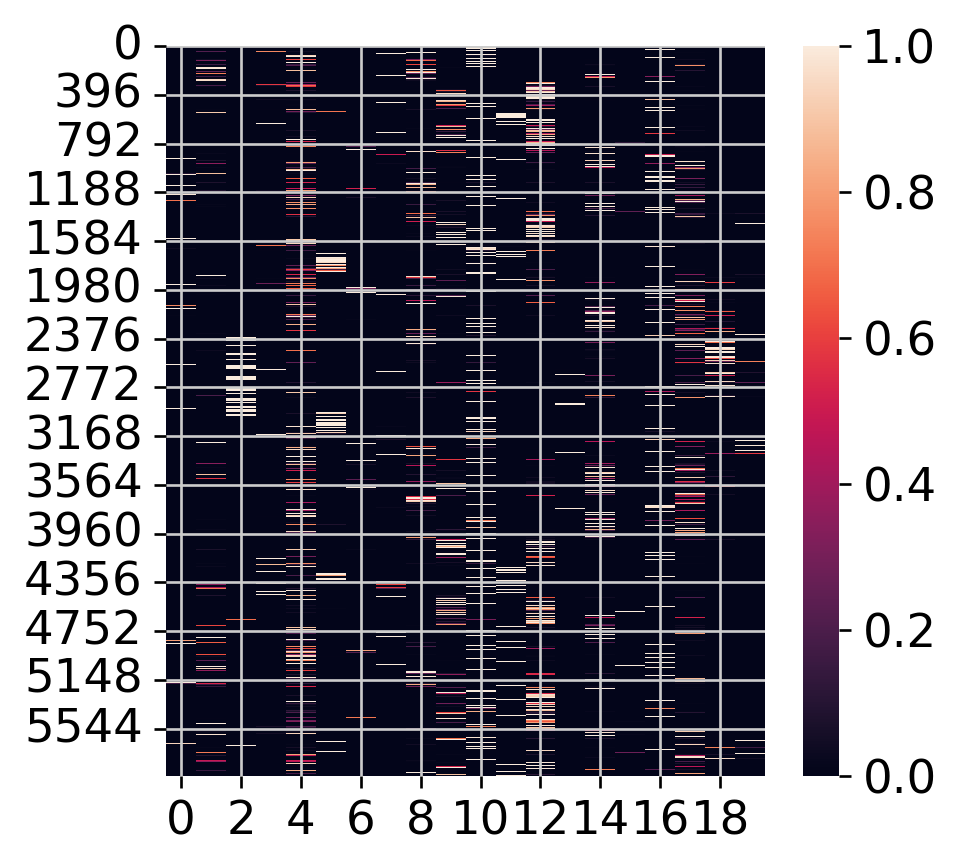

In [20]:
sns.heatmap(F.softmax(logits, dim=1).detach().cpu())

<Axes: >

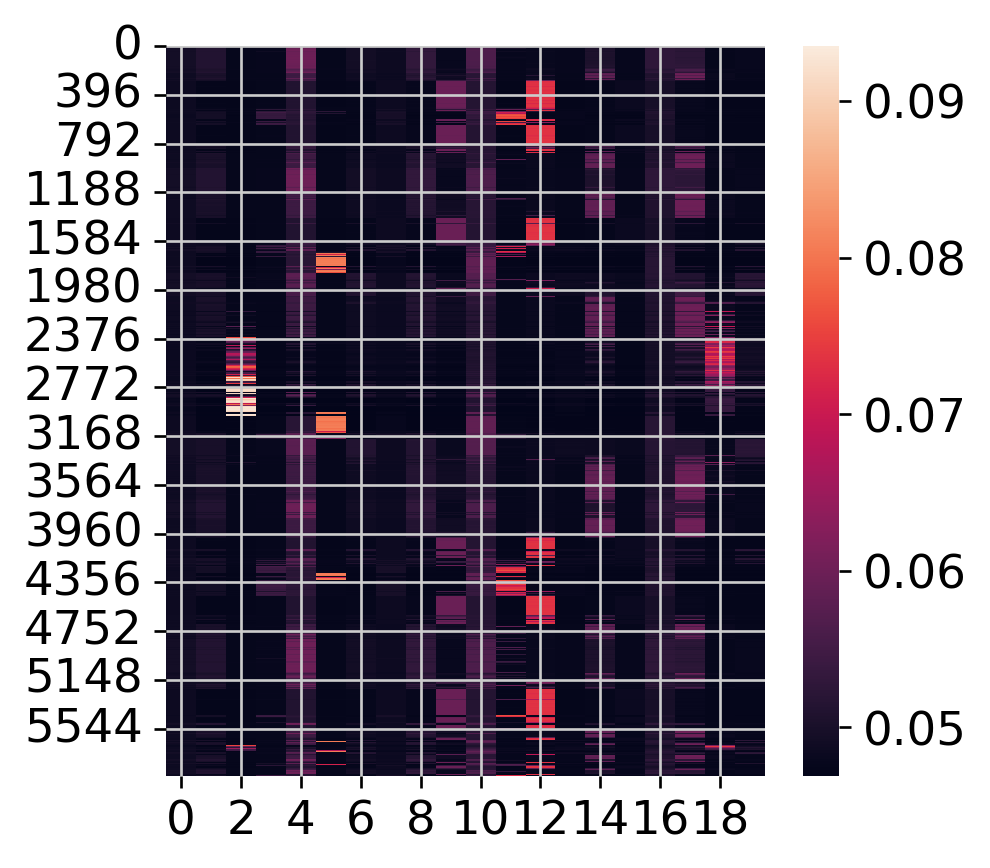

In [21]:
sns.heatmap(F.softmax(recon_celltype, dim=1).detach().cpu())

In [22]:
def viz_hierarchical_domain2(z, x, y, K_final=15, colorspace="hsv", viz_dendrogram=True, viz_spatial=True, save_fig=False, figurename="figure.png"):
    # ───────────────────── Library ─────────────────────
    import numpy  as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.colors  as mcolors
    import matplotlib.patches as mpatches
    from collections import defaultdict
    from sklearn.preprocessing    import StandardScaler
    from sklearn.cluster          import MiniBatchKMeans
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    from scipy.cluster.hierarchy import to_tree
    
    def STEP1_prototype_compression_hierarchical_clustering(z, n_proto=1000, random_state=42):
        scaler    = StandardScaler()
        z_std     = scaler.fit_transform(z)
        mbk       = MiniBatchKMeans(n_clusters=n_proto, batch_size=8192,
                                    random_state=random_state, n_init="auto")
        proto_id  = mbk.fit_predict(z_std)                 # each cell → prototype ID
        protos    = mbk.cluster_centers_                  # (n_proto, n_features)
        link_mat  = linkage(protos, method="ward", metric="euclidean")     
        return proto_id, link_mat
    
    def STEP2_specify_k_final_clusters(link_mat, K_final=K_final):
        proto_cluster  = fcluster(link_mat, K_final, criterion="maxclust")  # (n_proto,)
        clust_to_protos = defaultdict(list)
        for pid, c in enumerate(proto_cluster):
            clust_to_protos[c].append(pid)
        # "Representative leaf number" of each final cluster (smallest prototype ID)
        clust_rep_leaf = {c: min(leaf_ids) for c, leaf_ids in clust_to_protos.items()}
        rep_leaves_set = set(clust_rep_leaf.values())     
        return proto_cluster, clust_rep_leaf, rep_leaves_set
    
    def STEP3_color_palette_mapping(link_mat):
        def _assign_color(node, h0, h1, depth, out, colorspace=colorspace):
            """
            Recursively assign a unique color to each leaf.
            
            Parameters
            ----------
            node : scipy.cluster.hierarchy.ClusterNode
            h0, h1 : float
                Start and end hue (or analogous range) values
            depth : int
                Current depth in tree (not used here but could help for other color logic)
            out : dict
                Mapping of node.id → RGB tuple
            colorspace : str
                Color space to use. One of ["hsv", "hsl", "lab"]
            """
            import colorsys
            from colorsys import hsv_to_rgb, hls_to_rgb
            from matplotlib import colors as mcolors
            try:
                from colormath.color_objects import LabColor, sRGBColor
                from colormath.color_conversions import convert_color
            except ImportError:
                pass
            
            if node.is_leaf():
                h = (h0 + h1) / 2
        
                if colorspace == "hsv":
                    rgb = hsv_to_rgb(h, 0.55, 0.90)
        
                elif colorspace == "hsl":
                    rgb = hls_to_rgb(h, 0.72, 0.55)  # lightness, saturation
        
                elif colorspace == "lab":
                    # L fixed, a and b interpolated
                    a = -60 + h * 120  # -60 ~ +60
                    b =  40 - h * 80   # 40 ~ -40
                    lab = LabColor(lab_l=75, lab_a=a, lab_b=b)
                    rgb_obj = convert_color(lab, sRGBColor)
                    rgb = (rgb_obj.clamped_rgb_r, rgb_obj.clamped_rgb_g, rgb_obj.clamped_rgb_b)
        
                else:
                    raise ValueError(f"Unsupported colorspace: {colorspace}")
        
                out[node.id] = rgb
        
            else:
                mid = (h0 + h1) / 2
                _assign_color(node.get_left(),  h0,  mid, depth + 1, out, colorspace)
                _assign_color(node.get_right(), mid, h1,  depth + 1, out, colorspace)
        
        root, _ = to_tree(link_mat, rd=True)   # deterministic tree object
        proto_rgb = {}
        _assign_color(root, 0.0, 1.0, 0, proto_rgb)      # {leaf_id: (r,g,b)}
        proto_to_color = {pid: mcolors.to_hex(rgb) for pid, rgb in proto_rgb.items()}
        cluster_to_color = {c: proto_to_color[clust_rep_leaf[c]] for c in clust_rep_leaf}
        return proto_to_color, cluster_to_color
    
    def STEP4_visualization(x, y, proto_id, proto_to_color,
                            proto_cluster, clust_rep_leaf,
                            cluster_to_color, link_mat,
                            viz_dendrogram=viz_dendrogram, viz_spatial=viz_spatial,
                            save_fig=save_fig, figurename=figurename):
    
        rep_leaves_set = set(clust_rep_leaf.values())
        
        fig = plt.figure(figsize=(13, 6))
        n_cols = int(viz_dendrogram) + int(viz_spatial)
        gs = fig.add_gridspec(1, n_cols, width_ratios=[1]*n_cols, wspace=0.25)
    
        ax_idx = 0
    
        # ────── A. Dendrogram ──────
        if viz_dendrogram:
            ax_d = fig.add_subplot(gs[ax_idx])
            ax_idx += 1
    
            def leaf_color_func(id_):
                return proto_to_color.get(id_, "#555555")
    
            def leaf_label_func(id_):
                if id_ in rep_leaves_set:
                    return f"({id_})  ■"
                else:
                    return ""
    
            dendrogram(link_mat,
                       orientation="left",
                       leaf_label_func=leaf_label_func,
                       leaf_font_size=8,
                       link_color_func=leaf_color_func,
                       color_threshold=0,
                       ax=ax_d)
    
            ax_d.set_title("UPGMA dendrogram\n(representative leaves only)", fontsize=10)
            ax_d.tick_params(left=False, labelleft=False)
            ax_d.set_xlabel("Distance")
    
            for label in ax_d.get_yticklabels():
                try:
                    id_ = int(label.get_text().strip("()■ "))
                    if id_ in proto_to_color:
                        label.set_color(proto_to_color[id_])
                except:
                    continue
    
        # ────── B. Spatial Plot ──────
        if viz_spatial:
            ax_s = fig.add_subplot(gs[ax_idx])
    
            # Color and representative leaf
            hc_leaf = [clust_rep_leaf[proto_cluster[pid]] for pid in proto_id]
            hc_color = [proto_to_color[pid] for pid in proto_id]
    
            ax_s.scatter(x, y, c=hc_color, s=4, linewidth=0)
    
            # Adjust crop range 
            xr, yr = (x.max()-x.min()), (y.max()-y.min())
            
            # Visualize representative leaf number text
            cent = pd.DataFrame({"x": x, "y": y, "leaf": hc_leaf}) \
                     .groupby("leaf")[["x", "y"]].median()
    
            x_lo, x_hi = ax_s.get_xlim()
            y_lo, y_hi = ax_s.get_ylim()
    
            for lf, (cx, cy) in cent.iterrows():
                if x_lo < cx < x_hi and y_lo < cy < y_hi:
                    ax_s.text(cx, cy, f"({lf})",
                              ha="center", va="center",
                              fontsize=8, weight="bold")
    
            # Add legends
            handles = [mpatches.Patch(color=cluster_to_color[c],
                                      label=f"({clust_rep_leaf[c]})")
                       for c in sorted(cluster_to_color)]
            leg = ax_s.legend(handles=handles, title="Hierarchical leaf\n(representative)",
                              bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
            leg._legend_box.align = "left"
    
            ax_s.axis("off")
            ax_s.set_title("Spatial feature plot – clusters labelled by leaf index", pad=6)
    
        # ────── Save or Show ──────
        plt.tight_layout()
        if save_fig:
            plt.savefig(filename, dpi=300)
        plt.show()

    proto_id, link_mat = STEP1_prototype_compression_hierarchical_clustering(z)
    proto_cluster, clust_rep_leaf, rep_leaves_set = STEP2_specify_k_final_clusters(link_mat, K_final = K_final)
    proto_to_color, cluster_to_color = STEP3_color_palette_mapping(link_mat)
    STEP4_visualization(x, y, proto_id, proto_to_color,proto_cluster, clust_rep_leaf,
                        cluster_to_color, link_mat,viz_dendrogram, viz_spatial, save_fig)

/tmp/ipykernel_1208051/589695176.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


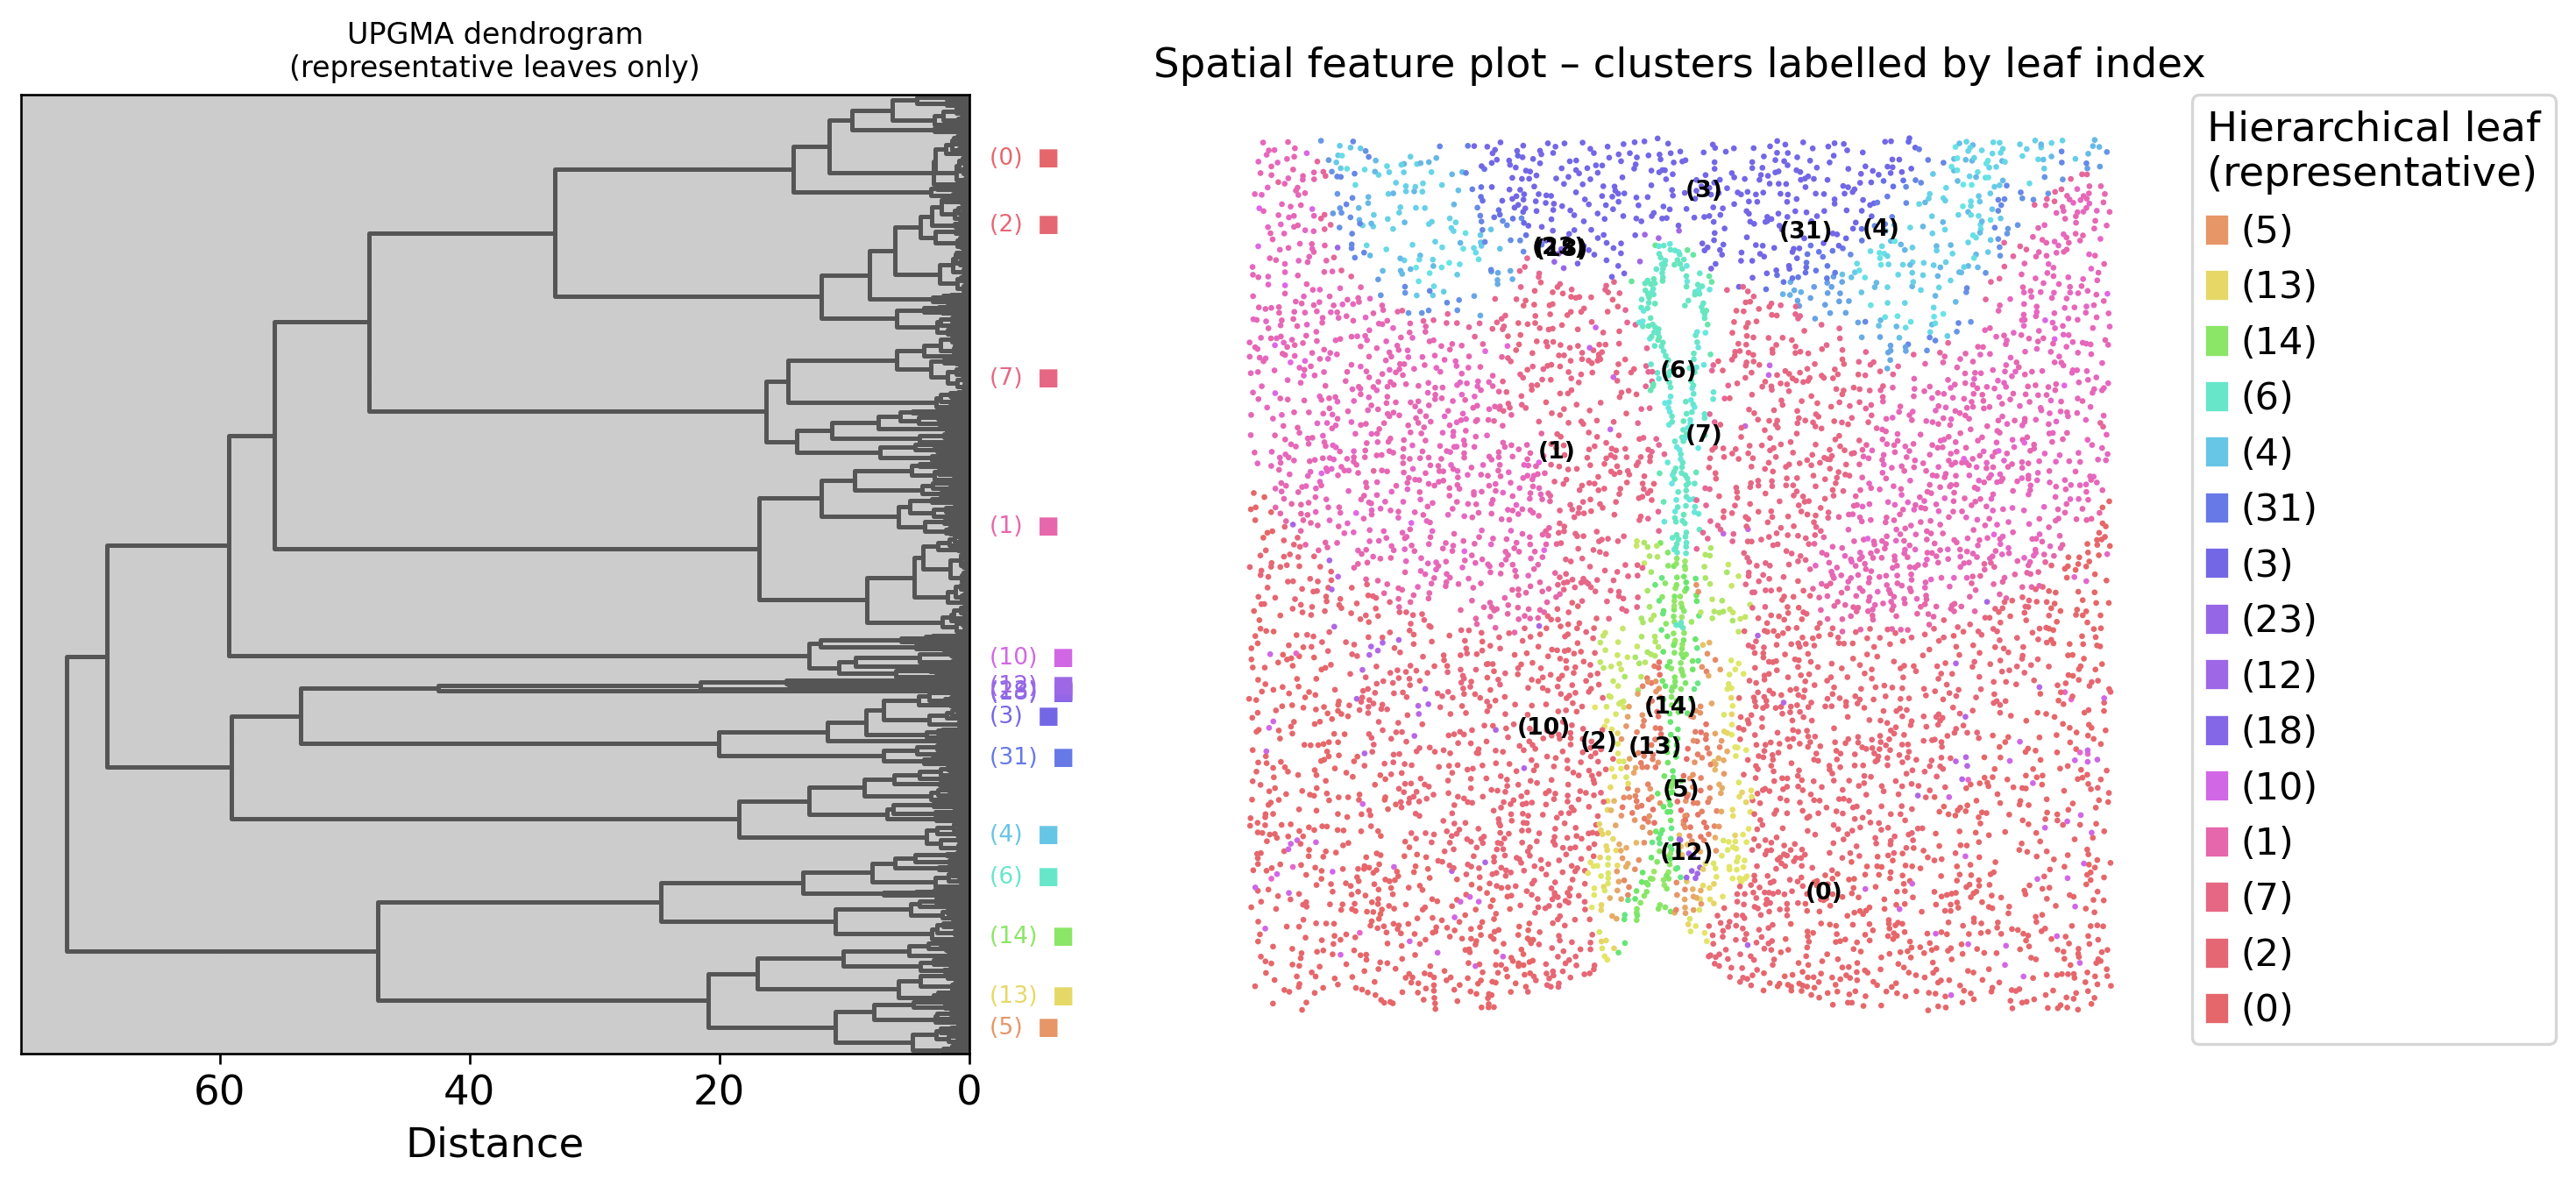

In [23]:
viz_hierarchical_domain2(p.detach().cpu(), spatial_coords.x, spatial_coords.y)

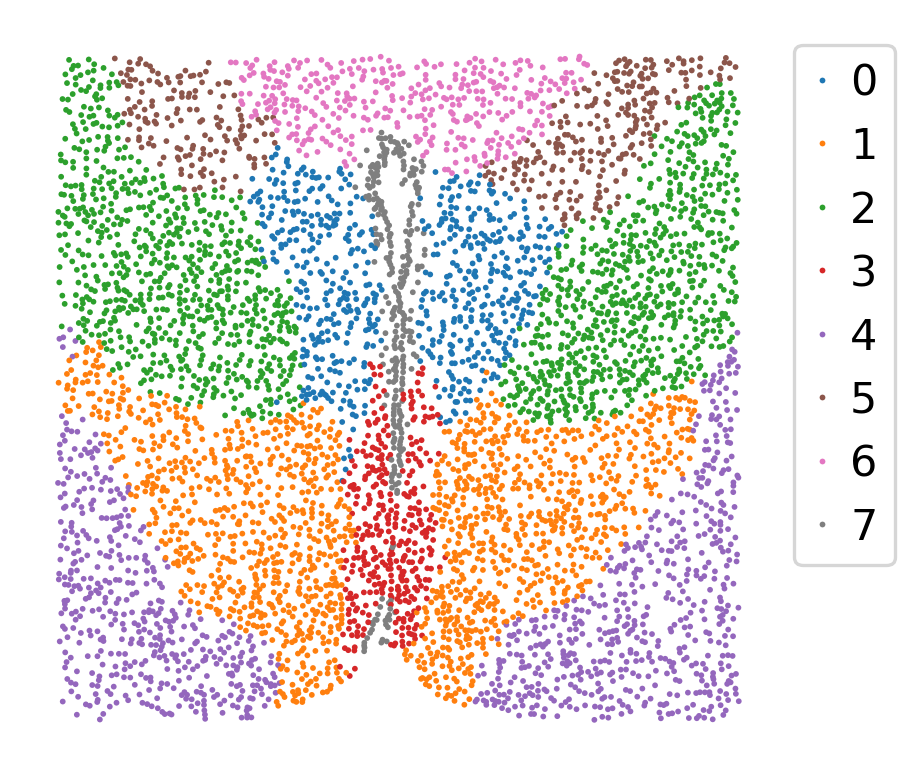

In [24]:
# Ensure your model and data are on the correct device
#pred_labels = GaussianMixture(n_components=8, random_state=0).fit_predict(z)
pred_labels = KMeans(n_clusters=8, random_state=0).fit_predict(p.detach().cpu())
#pred_labels = torch.argmax(p.detach().cpu(), dim=1).to(torch.int64)

seaborn.scatterplot(x=spatial_coords.x, y=spatial_coords.y, hue=pred_labels, palette='tab10', s=3, linewidth=0)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.axis('off')
plt.show()

#adjusted_rand_score(pred_labels, true_domains)

In [25]:
adjusted_rand_score(pred_labels, true_domains)

0.5907522946347349